The development of drugs is critical in providing therapeutic options
for patients suffering from chronic and terminal illnesses. “Target Drug”, in particular,
is designed to enhance the patient's health and well-being without causing
dependence on other medications that could potentially lead to severe and
life-threatening side effects. These drugs are specifically tailored to treat a particular
disease or condition, offering a more focused and effective approach to treatment,
while minimising the risk of harmful reactions.
The objective in this assignment is to develop a predictive model which will predict
whether a patient will be eligible*** for “Target Drug” or not in next 30 days. Knowing
if the patient is eligible or not will help physician treating the patient make informed
decision on the which treatments to give.

## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import *
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,recall_score

plt.rcParams['figure.figsize'] = [15,8]


import warnings
warnings.filterwarnings('ignore')

C:\Users\Subaranjani\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset Setup

In [2]:
# Read the dataset
df=pd.read_parquet('train.parquet')
df

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


## Positive and Negative Set

To create the positive and negative sets, consider patients who have taken the "Target Drug" and use the time aspect to determine eligibility. Define patients who took the "Target Drug" as positive cases and select negative cases randomly from patients who did not take the "Target Drug" within the next 30 days.

In [3]:
# Positive set

data = df.copy()
positive_set = data[data['Incident'] == 'TARGET DRUG']

# Negative set
negative_set = pd.DataFrame()

for index, row in positive_set.iterrows():
    patient_uid = row['Patient-Uid']
    date = row['Date']
    next_30_days = pd.date_range(start=date, periods=30)
    temp_df = data[(data['Patient-Uid'] == patient_uid) & (data['Date'].isin(next_30_days))]
    if temp_df.empty:
        negative_sample = data[(data['Patient-Uid'] == patient_uid)].sample(n=1)
        negative_set = pd.concat([negative_set, negative_sample])

In [4]:
positive_set

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG
...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG


In [5]:
negative_set

""


No records in Negative set. Hence all patients in the dataset who took 'TARGET DRUG' has taken again within 30 days. Hence we will create Eligible column which has both positive and negative set by adding '1' and '0'.

Positive Set:
        Identify the patients who have taken the "Target Drug" at least once.

Negative Set:
        Identify the patients who have not taken the "Target Drug" at any point.

In [6]:
len(df['Patient-Uid'].unique())

27033

In [7]:
p=df[df['Incident']=='TARGET DRUG']['Patient-Uid'].unique()
len(p)

9374

In [8]:
n=df[df['Incident']!='TARGET DRUG']['Patient-Uid'].unique()
len(n)

27033

In [9]:
p[0]

'a0eb742b-1c7c-11ec-8f61-16262ee38c7f'

In [ ]:
# Creating Positive set
a=0
for i in p:
    ind=df[df['Patient-Uid']==i].index
    for j in ind:
        a+=1
        print(a)
        df.loc[j,'Eligible']=1

In [11]:
# Creating Negative set
df['Eligible'].fillna(0,inplace=True)

In [12]:
df['Eligible'].value_counts()

Eligible
0.0    1617386
1.0    1603482
Name: count, dtype: int64

## Preprocessing 

In [13]:
encoder = LabelEncoder()
df['Patient-Uid']=encoder.fit_transform(df['Patient-Uid'])
df['Incident']=encoder.fit_transform(df['Incident'])
df['Date']=pd.to_numeric(df.Date)

In [14]:
df.head()

,Patient-Uid,Date,Incident,Eligible
0,0,1552089600000000000,19,0.0
1,1,1431734400000000000,19,0.0
3,2,1517270400000000000,20,0.0
4,3,1429660800000000000,0,0.0
8,4,1466208000000000000,1,1.0


## Split the Train and Test Dataset

In [15]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Defining Functions

In [17]:
def confusion_matrix_plot(model):
    ypred = model.predict(X_test)
    cm = confusion_matrix(y_test, ypred)
    cm = np.rot90(cm , 2)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:1','Predicted:0'], index = ['Actual:1','Actual:0'])
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
                linewidths = 0.1, annot_kws = {'size':20})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

In [18]:
def roc_plot(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))
    plt.grid(True)

In [19]:
def creport(model):
    ypred = model.predict(X_test)
    cr = classification_report(y_test, ypred)
    return cr

In [20]:
def accuracy(y_test , ypred):
    auc = accuracy_score(y_test , ypred)
    return auc

In [21]:
def f1(y_test , ypred):
    f = f1_score(y_test, ypred, average='macro')
    return f

In [22]:
def recall(y_test , ypred):
    f = recall_score(y_test, ypred)
    return recall

## Model Building

### Logistic Regression Model

In [23]:
logistic_model = LogisticRegression(random_state=0, penalty = 'l2')
logistic_model.fit(X_train,y_train)

LogisticRegression(random_state=0)

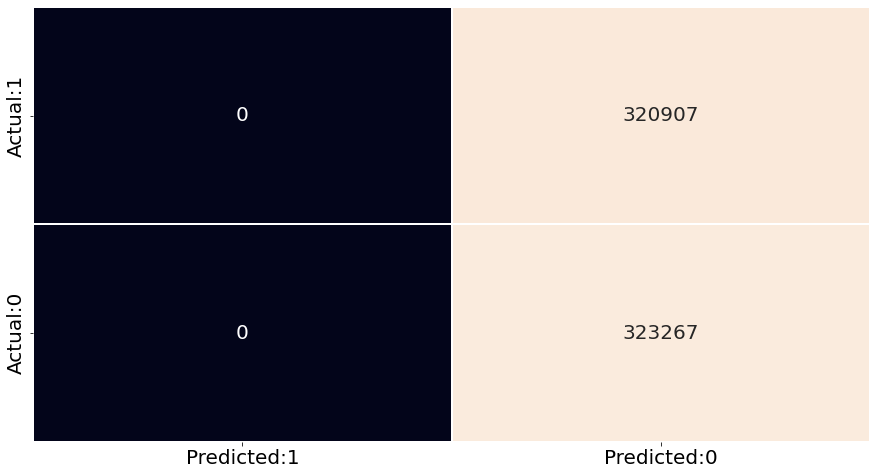

In [24]:
confusion_matrix_plot(logistic_model)

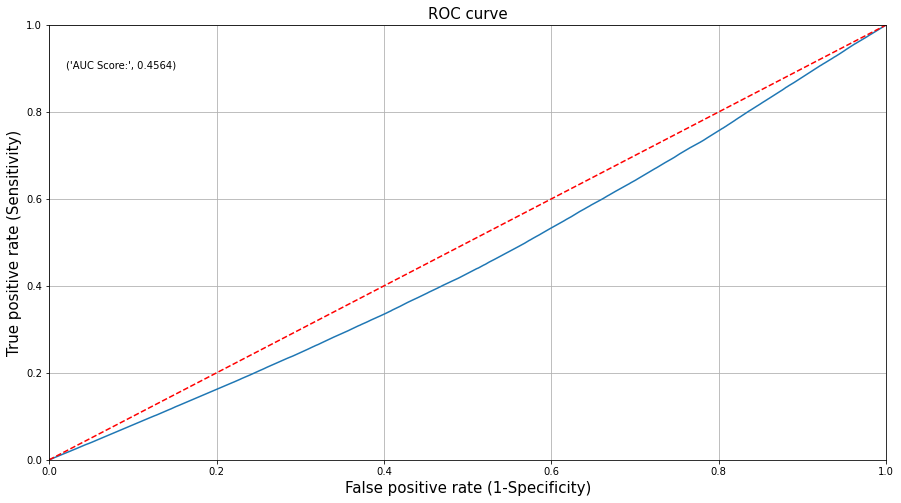

In [25]:
roc_plot(logistic_model)

In [26]:
print(creport(logistic_model))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    323267
         1.0       0.00      0.00      0.00    320907

    accuracy                           0.50    644174
   macro avg       0.25      0.50      0.33    644174
weighted avg       0.25      0.50      0.34    644174



### Naiive Bayes Model

In [27]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

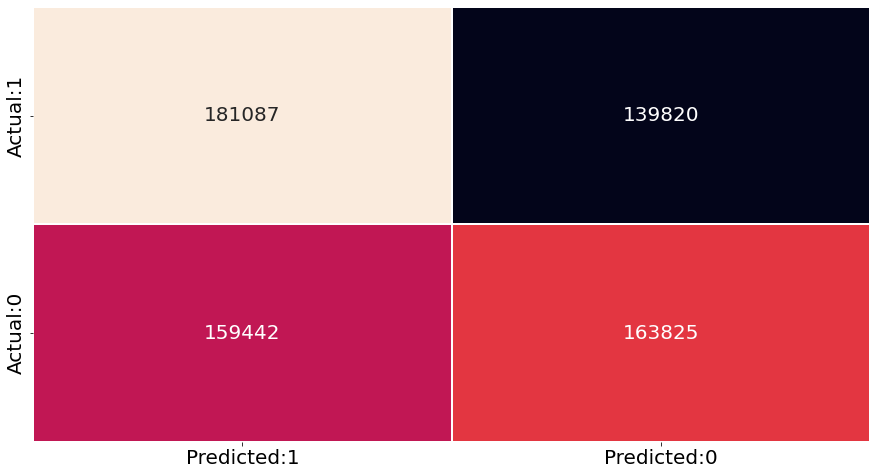

In [28]:
confusion_matrix_plot(gnb)

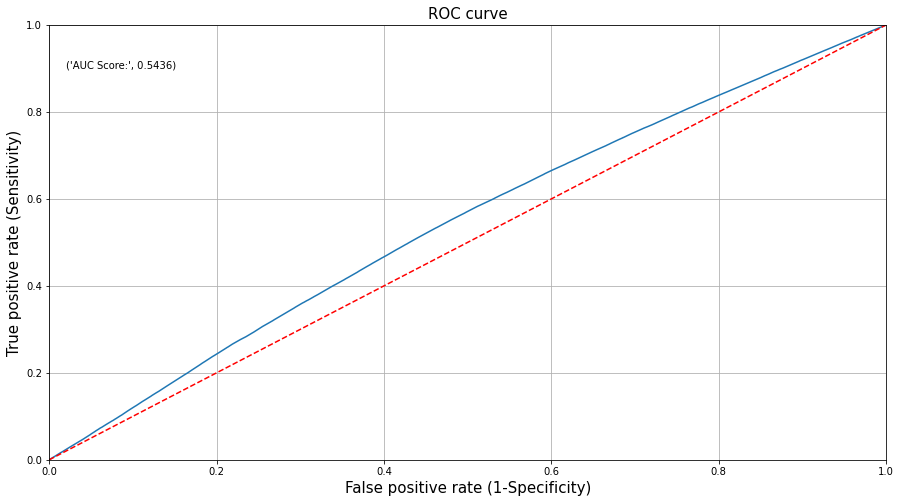

In [29]:
roc_plot(gnb)

In [30]:
print(creport(gnb))

              precision    recall  f1-score   support

         0.0       0.54      0.51      0.52    323267
         1.0       0.53      0.56      0.55    320907

    accuracy                           0.54    644174
   macro avg       0.54      0.54      0.54    644174
weighted avg       0.54      0.54      0.54    644174



### Random Forest Classifier Model

In [31]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

RandomForestClassifier()

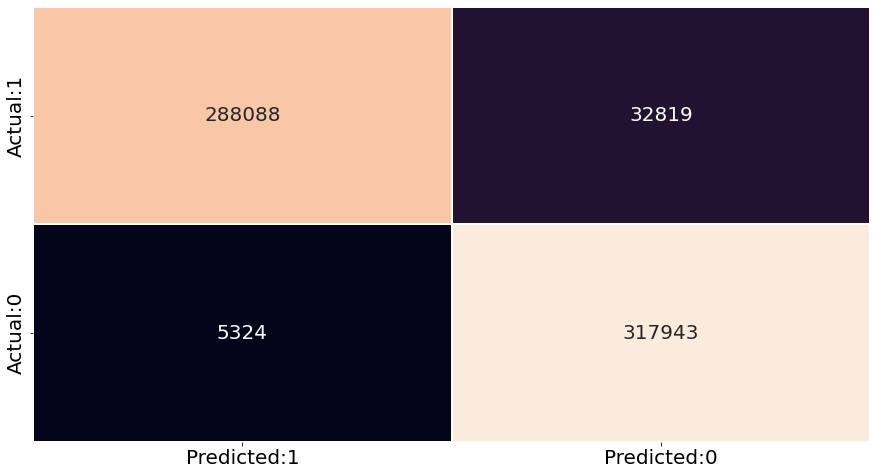

In [32]:
confusion_matrix_plot(rf)

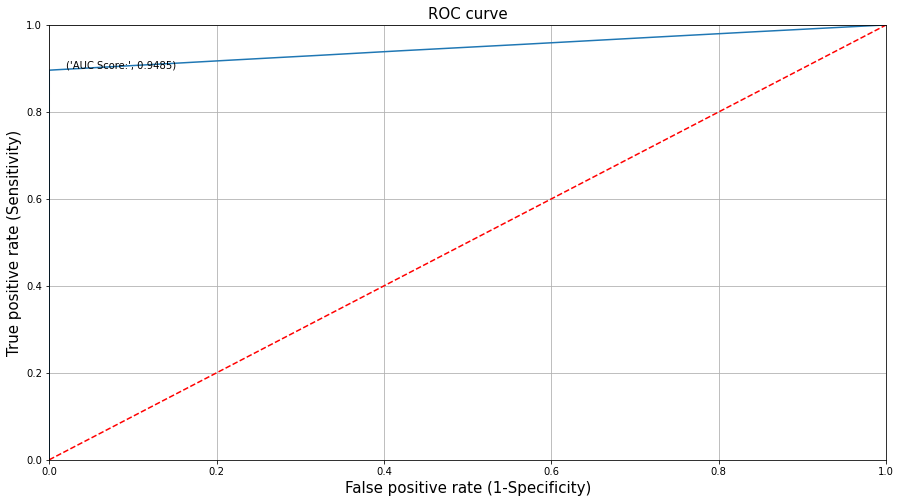

In [33]:
roc_plot(rf)

In [34]:
print(creport(rf))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94    323267
         1.0       0.98      0.90      0.94    320907

    accuracy                           0.94    644174
   macro avg       0.94      0.94      0.94    644174
weighted avg       0.94      0.94      0.94    644174



### Adaboost Classifier Model

In [35]:
ab = AdaBoostClassifier(n_estimators=250, learning_rate = 0.01, random_state=0)
ab.fit(X_train , y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=250, random_state=0)

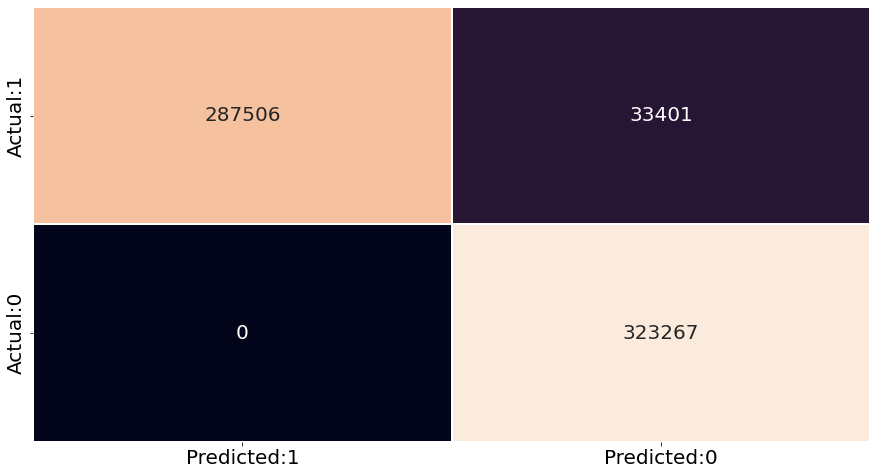

In [36]:
confusion_matrix_plot(ab)

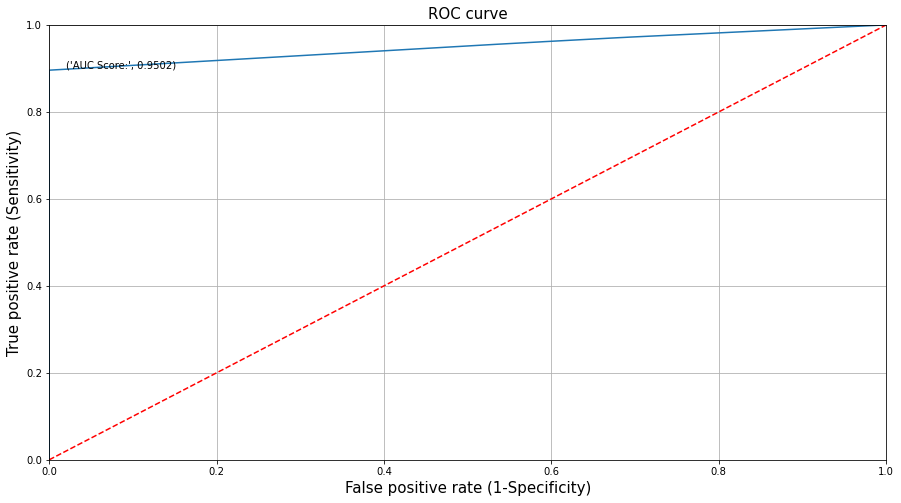

In [37]:
roc_plot(ab)

In [38]:
print(creport(ab))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    323267
         1.0       1.00      0.90      0.95    320907

    accuracy                           0.95    644174
   macro avg       0.95      0.95      0.95    644174
weighted avg       0.95      0.95      0.95    644174



### XGBoost Classifier Model

In [39]:
xgb = XGBClassifier(random_state= 0 , learning_rate= 0.2, n_estimators= 100)
xgb.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

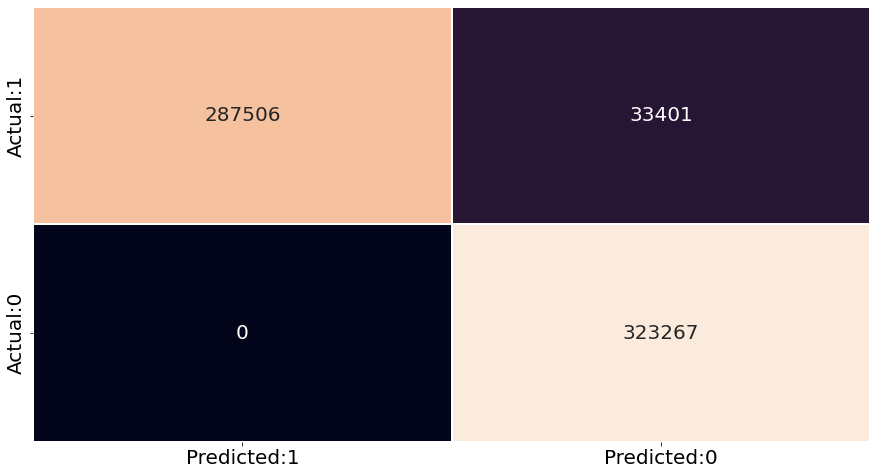

In [40]:
confusion_matrix_plot(xgb)

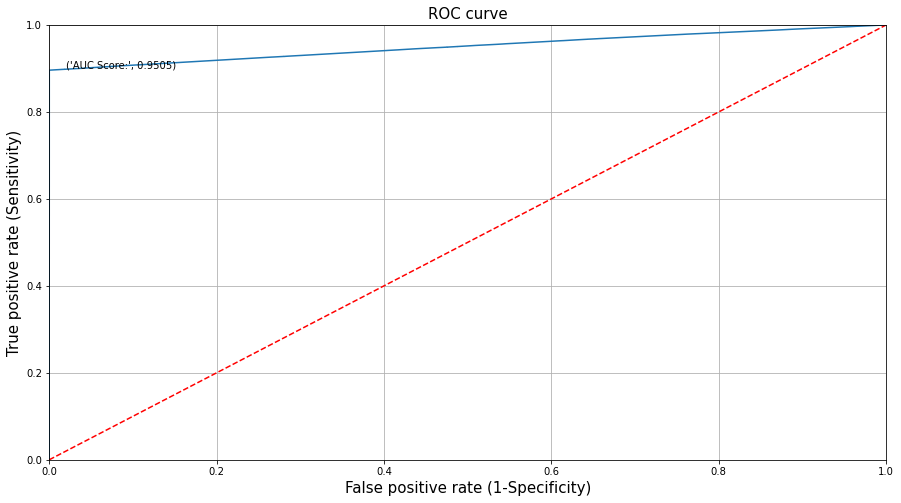

In [41]:
roc_plot(xgb)

In [42]:
print(creport(xgb))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    323267
         1.0       1.00      0.90      0.95    320907

    accuracy                           0.95    644174
   macro avg       0.95      0.95      0.95    644174
weighted avg       0.95      0.95      0.95    644174



## Model Performance

In [43]:
# Training Set Predictions
y_predtr = logistic_model.predict(X_train)
y_pred1tr = gnb.predict(X_train)
y_pred2tr = rf.predict(X_train)
y_pred3tr = ab.predict(X_train)
y_pred4tr = xgb.predict(X_train)

In [44]:
# Test Set Predictions
y_pred = logistic_model.predict(X_test)
y_pred1 = gnb.predict(X_test)
y_pred2 = rf.predict(X_test)
y_pred3 = ab.predict(X_test)
y_pred4 = xgb.predict(X_test)

# Displaying Score Card

In [53]:
# Comparison of Different Models wrt Performance Metrics
comp = pd.DataFrame({'Model':['Logistic Regression','Naive Bayes', 'Random Forest','AdaBoost','XGBoost'],
                    'Train Accuracy':[accuracy(y_train,y_predtr), accuracy(y_train,y_pred1tr), accuracy(y_train,y_pred2tr),
                                      accuracy(y_train,y_pred3tr), accuracy(y_train,y_pred4tr)],
                    'Test Accuracy':[accuracy(y_test,y_pred), accuracy(y_test,y_pred1), accuracy(y_test,y_pred2),
                                      accuracy(y_test,y_pred3), accuracy(y_test,y_pred4)],
                    'Test f1-Score':[f1(y_test,y_pred), f1(y_test,y_pred1), f1(y_test,y_pred2),
                                      f1(y_test,y_pred3), f1(y_test,y_pred4)]}
                    )

print(comp)

                 Model  Train Accuracy  Test Accuracy  Test f1-Score
0  Logistic Regression        0.502240       0.501832       0.334146
1          Naive Bayes        0.535118       0.535433       0.535099
2        Random Forest        0.999078       0.940788       0.940660
3             AdaBoost        0.948270       0.948149       0.947989
4              XGBoost        0.948270       0.948149       0.947989


## Best Model

Random Forest is the best model. Even though the f1-scores of Adaboost and XGBoost classifier are high, Recall score of these classifier models show bias toward the patient who has not taken 'TARGET DRUG' which is Negative set in the dataset. So, Random Forest model with high accuracy and f1-score is selected for the Test Datset.

# Submission Dataset

In [46]:
# Load test dataset
test_data = pd.read_parquet('Test.parquet')
test_data.head(20)

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0
6,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-05-09,PRIMARY_DIAGNOSIS
7,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-07-07,DRUG_TYPE_8
8,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,TEST_TYPE_0
9,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2019-05-21,DRUG_TYPE_0
10,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-06-23,DRUG_TYPE_7


## Preprocessing

In [48]:
data_test=test_data.copy()

encoder = LabelEncoder()
data_test['Patient-Uid']=encoder.fit_transform(data_test['Patient-Uid'])
data_test['Incident']=encoder.fit_transform(data_test['Incident'])
data_test['Date']=pd.to_numeric(data_test.Date)
data_test.head()

,Patient-Uid,Date,Incident
0,0,1481155200000000000,19
1,0,1539734400000000000,0
2,0,1512086400000000000,10
3,0,1543968000000000000,1
4,0,1509753600000000000,19


## Model Predictions

In [49]:
# Make predictions on the test dataset using Random Forest Model
test_predictions = rf.predict(data_test)

In [50]:
# Create submission dataframe
submission_df = pd.DataFrame({'Patient-Uid': data_test['Patient-Uid'], 'label': test_predictions})
submission_df

,Patient-Uid,label
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,1.0
...,...,...
1372854,11481,0.0
1372856,11481,0.0
1372857,11481,0.0
1372858,11481,0.0


## Creating Submission Dataset

In [51]:
# Extract unique categorical values
unique_categories = test_data['Patient-Uid'].unique()

# Assign numerical labels
mapping_dict = {label: category for label, category in enumerate(unique_categories)}

# Print the mapping dictionary
print(mapping_dict)

{0: 'a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f', 1: 'a0f9e9f9-1c7c-11ec-b565-16262ee38c7f', 2: 'a0f9ea43-1c7c-11ec-aa10-16262ee38c7f', 3: 'a0f9ea7c-1c7c-11ec-af15-16262ee38c7f', 4: 'a0f9eab1-1c7c-11ec-a732-16262ee38c7f', 5: 'a0f9eae4-1c7c-11ec-9bdb-16262ee38c7f', 6: 'a0f9eb1c-1c7c-11ec-a373-16262ee38c7f', 7: 'a0f9eb4d-1c7c-11ec-8c2b-16262ee38c7f', 8: 'a0f9eb80-1c7c-11ec-91c3-16262ee38c7f', 9: 'a0f9ebb1-1c7c-11ec-882f-16262ee38c7f', 10: 'a0f9ebe4-1c7c-11ec-bff2-16262ee38c7f', 11: 'a0f9ec45-1c7c-11ec-9011-16262ee38c7f', 12: 'a0f9ec78-1c7c-11ec-9c94-16262ee38c7f', 13: 'a0f9eca8-1c7c-11ec-80ec-16262ee38c7f', 14: 'a0f9ecdf-1c7c-11ec-8ef1-16262ee38c7f', 15: 'a0f9ed11-1c7c-11ec-a61f-16262ee38c7f', 16: 'a0f9ed41-1c7c-11ec-b88a-16262ee38c7f', 17: 'a0f9ed71-1c7c-11ec-b3b7-16262ee38c7f', 18: 'a0f9eda2-1c7c-11ec-b287-16262ee38c7f', 19: 'a0f9edd1-1c7c-11ec-85c7-16262ee38c7f', 20: 'a0f9ee02-1c7c-11ec-9a86-16262ee38c7f', 21: 'a0f9ee31-1c7c-11ec-90d5-16262ee38c7f', 22: 'a0f9ee6c-1c7c-11ec-83e8-16262ee38c7f

In [52]:
# Assuming you have encoded categorical columns and made predictions
encoded_categorical_columns = submission_df['Patient-Uid'] # Encoded categorical columns from test dataset
predicted_labels = submission_df['label']  # Predicted labels


# Reverse the encoding and obtain the original categorical values
original_categorical_columns = [mapping_dict[encoded_value] for encoded_value in encoded_categorical_columns]

# Create the submission file
submission_data = {
    'Patient-Uid': original_categorical_columns,
    'label': predicted_labels
}

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv(r'final_submission.csv', index=False)

This 'final_submission.csv' file predict whether a patient will be eligible for “Target Drug” or not in next 30 days.
If label column shows '1' then the patient are Eligible for 'TARGET DRUG'. 
If label column shows '0' then the patient are not Eligible for 'TARGET DRUG'.